# Last Notebook - Dawson Pallotta


and add markdown cell explanations and in-code comments as needed

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import scipy.stats

In [2]:
#import and read dataset
df = pd.read_csv("C:/Users/student/Data Minning/featuresDefault.csv") #features for the Moodable/EMU dataset
print(df.shape)
df.head()

(114, 199)


,id,phq9,NumTexts,help,office,dance,money,wedding,domestic_work,sleep,...,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,colors,text_abbreviations
0,e122,7,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,e1526,20,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,e2806,6,142,0.000000,0.006337,0.003802,0.011407,0.000000,0.003802,0.003802,...,0.0,0.00000,0.003802,0.00000,0.001267,0.002535,0.001267,0.001267,0.002535,0.001267
3,e3702,0,58,0.013413,0.005961,0.000000,0.000000,0.007452,0.008942,0.004471,...,0.0,0.00149,0.017884,0.00149,0.013413,0.000000,0.016393,0.000000,0.000000,0.000000
4,e433,15,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
#sets the split for the data to define the scores in the data
split = 13
data = df[:]
d10 = []
for i in range(0, data.shape[0]):
    if int(data.phq9[i]) >= split:
        d10.append(1)
    else:
        d10.append(0)
data["phq9"] = d10

#checking values
print(sum(d10)/len(d10))
print(len(d10))

0.49122807017543857
114


## Pay attention

Update split to the split that results in the most balanced classes

## Machine learning code with comments added for you

In [4]:
#reading about python def https://www.w3schools.com/python/ref_keyword_def.asp
#sets the information and variables for calulating a confusion matrix which allows for finding balance accuracy
def get_ba(x,y,z,q):
    #fit model and make predictions
    clf.fit(x, list(y))
    y_pred = clf.predict(z)

    #evaluate model - testing
    conf_mat = confusion_matrix(list(q), y_pred)
    TN = conf_mat[0][0]
    TP = conf_mat[1][1]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    ba = (sens + spec)/2
    return ba

In [5]:
#sets the machine learning information for the different models being used
numberOfFeatures = 2 #set number of principal components
modelTypelist = ["NB", "LR", "SVC1", "SVC2", "SVC3", "SVC4", "kNN", "RF"]

train_ba_depression = []
test_ba_depression = []
rlist = []
mlist = []

for modelType in modelTypelist: 
    for r in range(50, 75):
        rlist.append(r)
        mlist.append(modelType)

        #create train/test sets
        df_train, df_test = train_test_split(data, test_size=0.3, stratify=data[["phq9"]], random_state = r)

        #save target variables
        train_targets = df_train.loc[:,["phq9"]]
        test_targets = df_test.loc[:,["phq9"]]

        #drop non-features: id and targets
        trainContent = df_train.drop(columns = ["id", "phq9"])
        testContent = df_test.drop(columns = ["id", "phq9"])

        #normalize before pca
        min_max_scaler = preprocessing.MinMaxScaler()  
        np_scaled = min_max_scaler.fit_transform(trainContent)
        featureSubset = pd.DataFrame(np_scaled)
        np_scaled2 =  min_max_scaler.transform(testContent)
        testSubset = pd.DataFrame(np_scaled2)

        #principal component analysis
        pca = PCA(n_components=numberOfFeatures)
        pca = pca.fit(featureSubset)
        X_pca = pca.transform(featureSubset)
        pcaDF = pd.DataFrame(X_pca)
        testSubset2 = pca.transform(testSubset)
        pca_test = pd.DataFrame(testSubset2)

        #upsampling to balance classes
        train_targets = train_targets.reset_index(drop = True)
        pcaDF_labels = pd.concat([pcaDF,train_targets], axis = 1) #reattach labels

        phq0 = pcaDF_labels[pcaDF_labels.phq9 == 0]
        phq1 = pcaDF_labels[pcaDF_labels.phq9 == 1]
        if phq0.shape[0]>phq1.shape[0]:
            phq_upsampled = resample(phq1, n_samples=(phq0.shape[0]-phq1.shape[0]), random_state=50)
            phq_up = pd.concat([pcaDF_labels, phq_upsampled])
        elif phq0.shape[0]<phq1.shape[0]:
            phq_upsampled = resample(phq0, n_samples=(phq1.shape[0]-phq0.shape[0]), random_state=50)
            phq_up = pd.concat([pcaDF_labels, phq_upsampled])

        #remove upsampled labels
        pca_phq_targets = phq_up.loc[:,["phq9"]]
        pca_phq_features = phq_up.drop(columns = ["phq9"])

        #select modeltype
        if modelType == "SVC1":
            clf = svm.SVC(kernel='rbf', random_state=r)
        elif modelType == "SVC2":
            clf = svm.SVC(kernel='linear', random_state=r)
        elif modelType == "SVC3":
            clf = svm.SVC(kernel='sigmoid', random_state=r)
        elif modelType == "SVC4":
            clf = svm.SVC(kernel='poly', random_state=r)
        elif modelType == "RF":
            clf = RandomForestClassifier(criterion="gini", max_depth=3, random_state=r)
        elif modelType == "kNN":
            clf = KNeighborsClassifier()
        elif modelType == "LR":
            clf = LogisticRegression(random_state=r)
        elif modelType == "NB":
            clf = GaussianNB()
        
        
        #train evaluate models
        ba = get_ba(pca_phq_features, pca_phq_targets["phq9"], pca_test, test_targets["phq9"])
        test_ba_depression.append(ba)
                
resultsDF = pd.DataFrame()
resultsDF["test_ba"] = test_ba_depression
resultsDF["random"] = rlist
resultsDF["model"] = mlist
resultsDF.head(100)

,test_ba,random,model
0,0.547386,50,NB
1,0.455882,51,NB
2,0.627451,52,NB
3,0.573529,53,NB
4,0.602941,54,NB
...,...,...,...
95,0.542484,70,SVC2
96,0.455882,71,SVC2
97,0.599673,72,SVC2
98,0.601307,73,SVC2


How many SVC methods are there? How do they differ? 
There are four different SVC methods that are being used, and they differ based on the kernel that they are using rbf looks at the Gaussian kernal, linear looks at the linear kernal, sigmoid looks at the sigmoid kernal, and poly looks at the polynominal kernal
What does 'rbf' stand for? Which kernel does it indicate is being used? Resources:
* https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/ 
* https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/
rbf stands for radial basis function, the gaussian kernal
Which methods assume the data follows a linear relationship? Are these methods parametric or nonparametric? 

The methods that assume the data follows a linear relationship are the linear method, SVC, and SVM, and it is parametric, but SVM can have nonlinear and nonparametric variations 

Which methods have some randomness in them? i.e which methods can produce different results on different runs even with the same data?
The models of SVC, random forests, and logistic regression all have aspects of randomness in them

## Plotting

In [6]:
#adds a list of bas to the tempDF results 
bas = []
for modelType in modelTypelist: 
    tempDF = resultsDF[resultsDF.model == modelType]
    bas.append(tempDF['test_ba'].to_numpy())

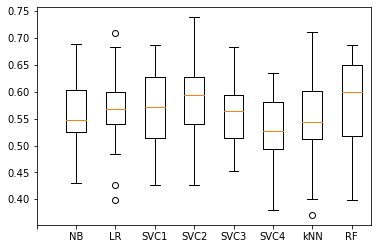

In [7]:
#prints the plot generated from the above code
plt.boxplot(bas)
plt.xticks(range(0, len(bas)+1), [' ']+ modelTypelist)
plt.show()

In [8]:
#prints the balance accuracy and standard deviation of each of the modles being used, and includes the min and max values
#for each models balanced accuracy
for modelType in modelTypelist: 
    tempDF = resultsDF[resultsDF.model == modelType]
    print(modelType + ": " + str(round(np.mean(tempDF["test_ba"]),2)) + " +- " + str(round(np.std(tempDF["test_ba"]),2)))
    print(min(tempDF["test_ba"]))
    print(max(tempDF["test_ba"]))

NB: 0.57 +- 0.07
0.4297385620915033
0.6879084967320261
LR: 0.57 +- 0.07
0.39869281045751637
0.7091503267973855
SVC1: 0.57 +- 0.08
0.42647058823529416
0.6862745098039216
SVC2: 0.59 +- 0.07
0.42647058823529416
0.738562091503268
SVC3: 0.56 +- 0.06
0.4526143790849674
0.6830065359477124
SVC4: 0.53 +- 0.06
0.38071895424836605
0.6339869281045751
kNN: 0.55 +- 0.08
0.3709150326797386
0.7107843137254902
RF: 0.58 +- 0.07
0.39869281045751637
0.6862745098039216


Using the commands min and max, print the minimum and maximum values.

Which method has the highest average balanced accuracy? highest max ba? highest min ba? lowest standard deviation?
The method with the highest average balanced accuracy is SVC 2 with .59, highest max ba is SVC 2 with .7385, higest min ba is SVC 3 with .45, and lowest standard deviation is SVC 3 and 4 with .06 
Which method is known for text classification? Did that method have the highest average balanced accuracy?
The method that is known for text classification is Naive Bayes, no it doesn't 

In [9]:
#prints the balanced accuracy's statistical significance and p-value
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'SVC1']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'SVC3']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'SVC4']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'NB']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'LR']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'kNN']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))
print(scipy.stats.ttest_ind(resultsDF[resultsDF.model == 'RF']["test_ba"], resultsDF[resultsDF.model == "SVC2"]["test_ba"]))

Ttest_indResult(statistic=-0.9197851677727142, pvalue=0.362284486126213)
Ttest_indResult(statistic=-1.3333757907922128, pvalue=0.18870209017092288)
Ttest_indResult(statistic=-3.0396990216782562, pvalue=0.003827208013189819)
Ttest_indResult(statistic=-0.8387951638135627, pvalue=0.40574222884294664)
Ttest_indResult(statistic=-0.9232555775747375, pvalue=0.3604919756345938)
Ttest_indResult(statistic=-1.6159962816820554, pvalue=0.11264968410368857)
Ttest_indResult(statistic=-0.24520417484043927, pvalue=0.8073436795423043)


Repeat the above line of code so that the results all pairwise comparisons that include the method with the highest average balanced accuracy can be viewed at the same time.

Does the method with the highest average balanced accuracy have statistically significantly better balanced accuracy scores than any of the other methods?
No, the model that has the most statistical significance is SVC 4 as its' p-value is .038